In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
train_data_file=pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test_data_file=pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

In [3]:
!pip install pyarrow
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score ,mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from typing import Tuple
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
SEED   = 2000

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
train_data_file.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [5]:
test_data_file.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


# Preprocessing

In [6]:
train_data_file = train_data_file.drop(columns=['id'])
test_data_file = test_data_file.drop(columns=['id'])

In [7]:
train_data_file['auxiliary'] = 0
test_data_file['auxiliary'] = 0
display(train_data_file.describe())
display(test_data_file.describe())

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,auxiliary
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.0
mean,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,...,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365,0.0
std,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,...,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063,0.0
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,...,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000,0.0
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000,0.0
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000,0.0
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000,0.0
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,...,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000,0.0


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,auxiliary
count,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,...,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.0
mean,44.426538,165.221322,67.125618,82.999892,1.004776,0.999483,1.024216,1.023980,122.475403,76.820676,...,55.922286,114.597404,14.793354,1.072798,0.892463,25.559616,26.565427,36.086888,0.195458,0.0
std,11.897138,8.837065,12.586569,8.946584,0.397690,0.385752,0.153719,0.152988,12.765542,9.018782,...,14.000552,26.943401,1.434296,0.340818,0.179927,9.504442,17.944195,30.928138,0.396555,0.0
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,18.000000,1.000000,5.000000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.0
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.0
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.0
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,33.000000,44.000000,0.000000,0.0
max,85.000000,190.000000,130.000000,127.700000,9.900000,9.900000,2.000000,2.000000,213.000000,140.000000,...,148.000000,1220.000000,21.100000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,0.0


In [8]:
auxiliary_df = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
auxiliary_df['auxiliary'] = 1

In [9]:
train_data_file= pd.concat([train_data_file, auxiliary_df])

In [10]:
train_data_file.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,auxiliary,id
count,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,...,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,318512.000000,159256.000000
mean,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,...,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365,0.500000,79627.500000
std,11.842267,8.818956,12.586178,8.957923,0.402112,0.392298,0.152968,0.151238,12.729295,8.994628,...,1.431211,0.347855,0.179346,9.464867,17.753042,31.204594,0.398490,0.496062,0.500001,45973.391572
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,...,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000,0.000000,39813.750000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000,0.500000,79627.500000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000,1.000000,119441.250000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,...,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000,1.000000,159255.000000


In [11]:
auxiliary_df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,auxiliary
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.0
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365,1.0
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063,0.0
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000,1.0
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000,1.0
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000,1.0
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000,1.0
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000,1.0


In [12]:
train_data_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318512 entries, 0 to 159255
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  318512 non-null  int64  
 1   height(cm)           318512 non-null  int64  
 2   weight(kg)           318512 non-null  int64  
 3   waist(cm)            318512 non-null  float64
 4   eyesight(left)       318512 non-null  float64
 5   eyesight(right)      318512 non-null  float64
 6   hearing(left)        318512 non-null  int64  
 7   hearing(right)       318512 non-null  int64  
 8   systolic             318512 non-null  int64  
 9   relaxation           318512 non-null  int64  
 10  fasting blood sugar  318512 non-null  int64  
 11  Cholesterol          318512 non-null  int64  
 12  triglyceride         318512 non-null  int64  
 13  HDL                  318512 non-null  int64  
 14  LDL                  318512 non-null  int64  
 15  hemoglobin           3

In [13]:
auxiliary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [14]:
train_data_file.isnull().sum()

age                         0
height(cm)                  0
weight(kg)                  0
waist(cm)                   0
eyesight(left)              0
eyesight(right)             0
hearing(left)               0
hearing(right)              0
systolic                    0
relaxation                  0
fasting blood sugar         0
Cholesterol                 0
triglyceride                0
HDL                         0
LDL                         0
hemoglobin                  0
Urine protein               0
serum creatinine            0
AST                         0
ALT                         0
Gtp                         0
dental caries               0
smoking                     0
auxiliary                   0
id                     159256
dtype: int64

In [15]:
auxiliary_df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
auxiliary              0
dtype: int64

# Creating Features

In [16]:
def create_features(df):
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    return df

# Improving the features

In [17]:
def massive_feature(df, ignore_list):
    features = [feat for feat in df.columns if feat not in ignore_list]

    for idx1, col_one in enumerate(features):
        for idx2, col_two in enumerate(features):
            if idx1 < idx2:
                df[col_one +'_to_'+ col_two] = df[col_one] / df[col_two]
    return df

In [18]:
def count_outliers(df, features):
    df_subset = df[features]
    clf = IsolationForest(contamination='auto')
    predictions = clf.fit_predict(df_subset)
    outlier_count_df = pd.DataFrame({
        'Outlier_Count': [(pred == -1) for pred in predictions]
    })
    total_outliers = outlier_count_df['Outlier_Count'].sum()
    df['Outlier_Count'] = outlier_count_df
    
    return df

In [19]:
ignore_list = ['id', 'smoking', 'auxiliary']
features = [feat for feat in train_data_file.columns if feat not in ignore_list]
train_data_file = count_outliers(train_data_file, features)
test_data_file = count_outliers(test_data_file, features)
display(train_data_file)
display(test_data_file)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,auxiliary,id,Outlier_Count
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,1,1.0,22,25,27,0,1,0,NaN,False
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,1,1.1,27,23,37,1,0,0,NaN,True
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,1,0.8,27,31,53,0,1,0,NaN,False
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,1,1.0,20,27,30,1,0,0,NaN,False
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,1,0.8,19,13,17,0,1,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,1,0.8,25,26,13,0,0,1,159251.0,False
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,1,0.6,21,20,18,0,0,1,159252.0,False
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,1,0.6,15,9,12,0,0,1,159253.0,False
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,...,1,1.1,22,17,37,0,1,1,159254.0,False


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,auxiliary,Outlier_Count
0,40,165,70,84.0,1.2,1.2,1,1,130,89,...,115,14.2,1,0.9,19,25,32,0,0,False
1,80,160,60,93.0,1.0,1.0,2,2,144,72,...,104,13.0,1,1.1,20,12,24,0,0,True
2,60,170,70,86.5,0.6,0.7,1,1,117,75,...,88,15.4,1,1.4,38,60,36,0,0,False
3,40,160,50,67.0,0.3,0.4,1,1,116,62,...,128,14.5,1,0.6,25,18,10,1,0,False
4,40,170,75,89.4,1.0,0.9,1,1,132,94,...,123,16.5,1,1.0,30,39,27,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,40,165,60,78.0,0.8,0.9,1,1,112,78,...,149,16.4,1,1.1,24,31,28,0,0,False
106167,40,170,85,95.0,1.2,1.2,1,1,130,90,...,100,16.0,2,1.0,25,31,38,0,0,False
106168,35,170,85,89.0,1.2,1.2,1,1,131,86,...,142,15.9,1,0.8,33,32,24,1,0,False
106169,40,160,60,67.0,0.7,0.8,1,1,120,80,...,103,13.9,1,0.6,42,36,32,0,0,False


# Feature Selection in the train dataset

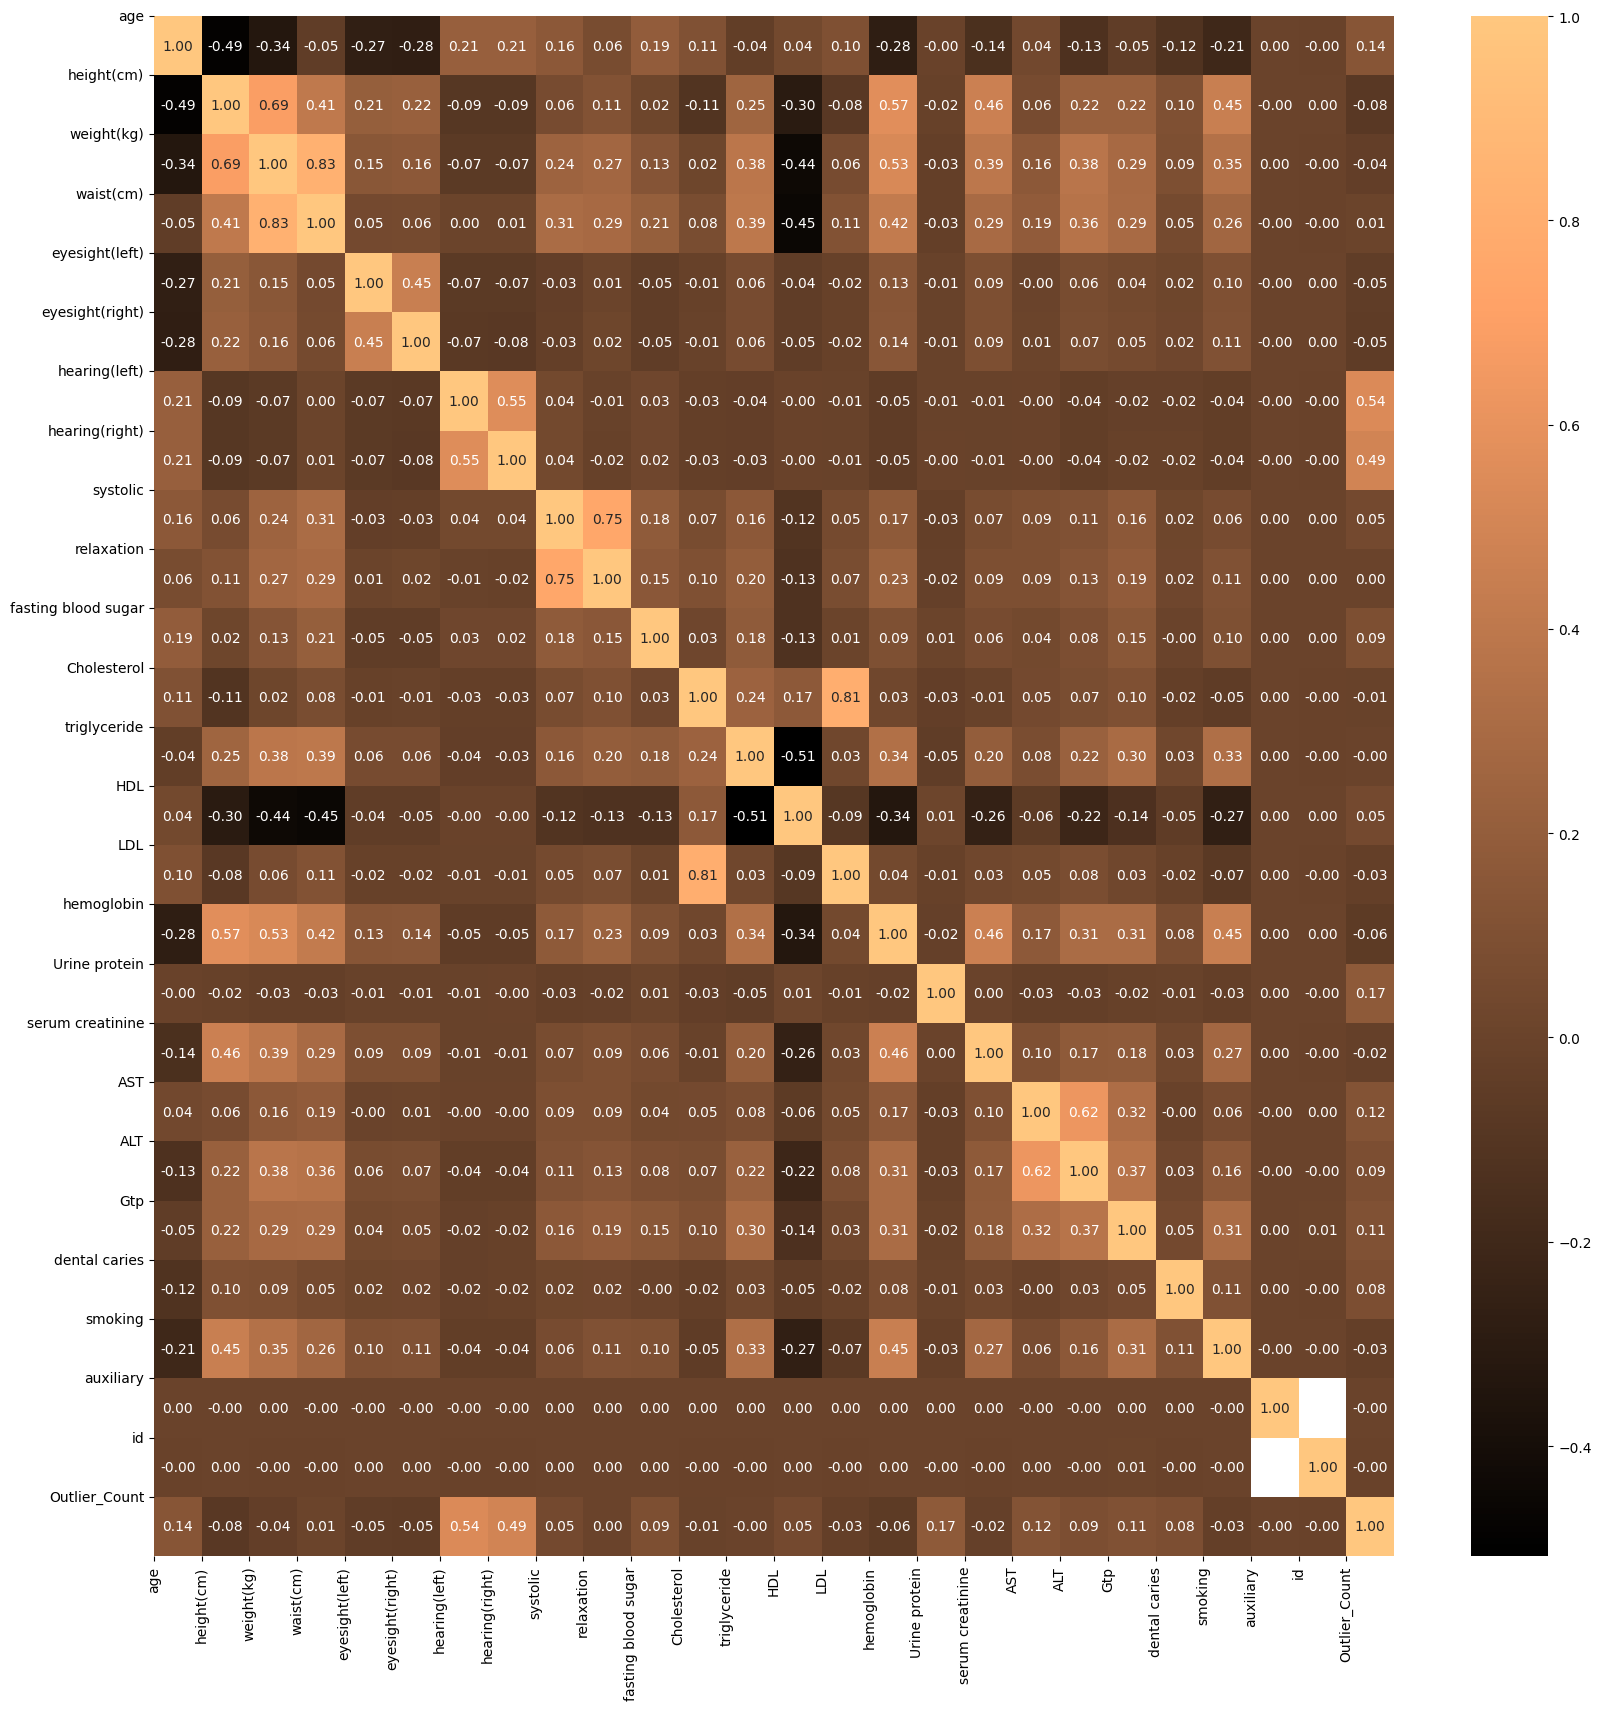

In [20]:
corr = train_data_file.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, cmap='copper', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [21]:
model_features = [col for col in train_data_file.columns if col not in ['id', 
                                                                 'smoking',
                                                                ]]
model_features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'auxiliary',
 'Outlier_Count']

# Parameter Tuning

In [22]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(train_data_file[model_features], train_data_file['smoking'], test_size=0.25, random_state=SEED)

    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0, step = 0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step = 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "n_estimators": trial.suggest_int("n_estimators", 256, 4096),
        "eta": trial.suggest_float("eta", 0.01, 0.5, step = 0.01),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "tree_method": "gpu_hist",
    }

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    model = xgb.train(param, xgb.DMatrix(X_train, label = y_train),

                     )
    
    y_pred = model.predict(xgb.DMatrix(X_test))
    loss = log_loss(y_test, y_pred)

    return loss

# XGB Classifier

In [23]:
def fit_xgboost_with_kfold(df, features, target_variable, parameters, n_splits=10,  random_state=SEED):
    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
 
    model = xgb.XGBClassifier(**parameters)

    fold_rocs = []
    fold_loglosses = []
    fold_predictions = []
    fold = 1

    for train_index, test_index in kfold.split(X[features], y):
        print(f'Training Fold: {fold} ...')
        X_train, X_test = X[features].iloc[train_index], X[features].iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train,
                  y_train,
                  eval_set = [(X_test, y_test)], 
                  verbose = 512,)
        
        best_iteration = model.best_iteration
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        fold_logloss = log_loss(y_test, y_pred_proba)
        fold_roc = roc_auc_score(y_test, y_pred_proba)
        fold_rocs.append(fold_roc)
        fold_loglosses.append(fold_logloss)
        fold += 1
        
        test_pred = model.predict_proba(test_data_file[features])[:,1]
        fold_predictions.append(test_pred)
        
        print('....', '\n')

    predictions = np.mean(fold_predictions, axis=0)

    print("Fold Accuracies:", fold_rocs)
    print("Fold Log Losses:", fold_loglosses)
    print("Mean AUC:", sum(fold_rocs) / len(fold_rocs))
    print("Mean Log Loss:", sum(fold_loglosses) / len(fold_loglosses))

    return model, predictions 

In [24]:
params1 = {'n_estimators'          : 2740,
          'max_depth'             : 8,
          'learning_rate'         : 0.045,
          'booster'               : 'gbtree',
          'subsample'             : 0.21000000000000002,
          'eta'                   : 0.25,
          'colsample_bytree'      : 1.0,
          'reg_lambda'            : 0.00021183538001644977,
          'reg_alpha'             : 2.806717085151949e-07,
          'gamma'                 : 1.633543174248018e-06,
          'grow_policy'           : 'lossguide',
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'gpu_hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }


xgboost_model, xgboost_predictions = fit_xgboost_with_kfold(train_data_file, 
                                                            model_features, 
                                                            target_variable='smoking',
                                                            parameters = params1, 
                                                            random_state=SEED, 
                                                            n_splits = 10)

Training Fold: 1 ...
[0]	validation_0-auc:0.83269
[512]	validation_0-auc:0.90018
[1024]	validation_0-auc:0.92444
[1536]	validation_0-auc:0.94313
[2048]	validation_0-auc:0.95709
[2560]	validation_0-auc:0.96782
[2739]	validation_0-auc:0.97083
.... 

Training Fold: 2 ...
[0]	validation_0-auc:0.83715
[512]	validation_0-auc:0.90380
[1024]	validation_0-auc:0.92740
[1536]	validation_0-auc:0.94550
[2048]	validation_0-auc:0.95921
[2560]	validation_0-auc:0.96973
[2739]	validation_0-auc:0.97277
.... 

Training Fold: 3 ...
[0]	validation_0-auc:0.83461
[512]	validation_0-auc:0.90374
[1024]	validation_0-auc:0.92808
[1536]	validation_0-auc:0.94616
[2048]	validation_0-auc:0.96000
[2560]	validation_0-auc:0.97071
[2739]	validation_0-auc:0.97371
.... 

Training Fold: 4 ...
[0]	validation_0-auc:0.83581
[512]	validation_0-auc:0.90495
[1024]	validation_0-auc:0.92876
[1536]	validation_0-auc:0.94667
[2048]	validation_0-auc:0.96023
[2560]	validation_0-auc:0.97073
[2739]	validation_0-auc:0.97361
.... 

Training

# Feature Importance

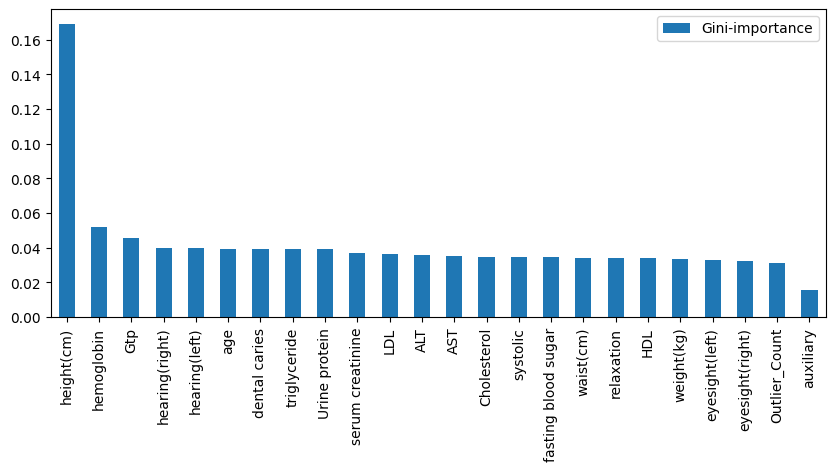

In [25]:
feats = {}
for feature, importance in zip(train_data_file[model_features].columns, xgboost_model.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=90, figsize=(10,4))
plt.show()

# Prediction of model

In [26]:
xgboost_predictions_df=pd.DataFrame(xgboost_predictions)
xgboost_predictions_df

,0
0,0.695759
1,0.142628
2,0.437033
3,0.006589
4,0.632606
...,...
106166,0.691600
106167,0.541296
106168,0.539616
106169,0.044139


# Submission

In [27]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
submission['smoking'] = xgboost_predictions_df
submission.to_csv('submission.csv', index = False)
submission

,id,smoking
0,159256,0.695759
1,159257,0.142628
2,159258,0.437033
3,159259,0.006589
4,159260,0.632606
...,...,...
106166,265422,0.691600
106167,265423,0.541296
106168,265424,0.539616
106169,265425,0.044139
